# Capstone 2: Lending Club - EDA

We are trying to solve if I could qualify for a loan from LendingClub (classification of approved or not approved loan), then, what would be rate/package look like (regressuib problem)? We will use the data to generate a model from and use use my own personal data as future data. 

Later on for fun, I could actually apply and submit a loan application to LendingClub and see what I would get for my real results, would my model's findings prove to be accurate? 

In [155]:
#Import necessary packages and load dataset

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sb_utils import save_file

In [156]:
loan_data = pd.read_csv('loan_data.csv')

In [157]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [158]:
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [159]:
loan_data = loan_data.rename(columns = {"credit.policy":"credit_policy", "int.rate":"interest_rate", "log.annual.inc":"log_annual_income", "dti":"debt_to_income_ratio", "days.with.cr.line":"days_with_credit_line", "revol.bal":"revolving_balance", "revol.util":"revolving_utilization", "inq.last.6mths":"inquiries_last_6months", "delinq.2yrs":"delinquency_2yrs", "pub.rec":"public_record", "not.fully.paid":"not_fully_paid"})
list(loan_data.columns)

['credit_policy',
 'purpose',
 'interest_rate',
 'installment',
 'log_annual_income',
 'debt_to_income_ratio',
 'fico',
 'days_with_credit_line',
 'revolving_balance',
 'revolving_utilization',
 'inquiries_last_6months',
 'delinquency_2yrs',
 'public_record',
 'not_fully_paid']

#  Plots of each Feature

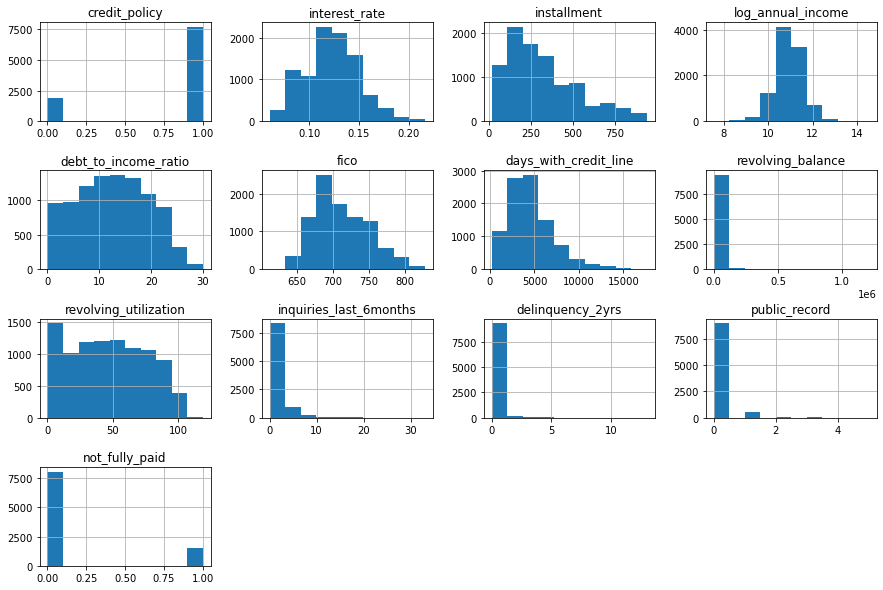

In [160]:
loan_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

#  Approved Loan Candidates

[Text(0, 0, '0'), Text(1, 0, '1')]

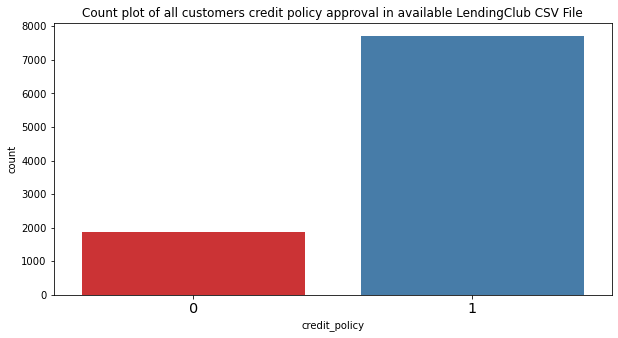

In [161]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=loan_data,
    x=loan_data['credit_policy'],
    palette='Set1'
)
plt.title('Count plot of all customers credit policy approval in available LendingClub CSV File')
chart.set_xticklabels(chart.get_xticklabels(), rotation=0, fontsize='x-large')

In [162]:
loan_data.credit_policy.value_counts()

1    7710
0    1868
Name: credit_policy, dtype: int64

In [163]:
#percentage calculation of customers who failed getting underwritten a loan

denied_underwriting = 1868/9578
print(denied_underwriting)

0.1950302777197745


It appears ~20% of customers failed to get an underwritten loan. In my case, I'm expecting I would qualify for a loan. So we can look into splitting the data into approved and non-approved credit policies.

The split of data will be "approved_loan_data" and "non_approved_loan_data".

In [164]:
approved_loan_data = loan_data[loan_data['credit_policy']==1]
print(approved_loan_data.head())

   credit_policy             purpose  interest_rate  installment  \
0              1  debt_consolidation         0.1189       829.10   
1              1         credit_card         0.1071       228.22   
2              1  debt_consolidation         0.1357       366.86   
3              1  debt_consolidation         0.1008       162.34   
4              1         credit_card         0.1426       102.92   

   log_annual_income  debt_to_income_ratio  fico  days_with_credit_line  \
0          11.350407                 19.48   737            5639.958333   
1          11.082143                 14.29   707            2760.000000   
2          10.373491                 11.63   682            4710.000000   
3          11.350407                  8.10   712            2699.958333   
4          11.299732                 14.97   667            4066.000000   

   revolving_balance  revolving_utilization  inquiries_last_6months  \
0              28854                   52.1                       0  

In [165]:
print(approved_loan_data.shape)

(7710, 14)


In [166]:
non_approved_loan_data = loan_data[loan_data['credit_policy']==0]
print(non_approved_loan_data.head())

      credit_policy             purpose  interest_rate  installment  \
7710              0  debt_consolidation         0.1608        35.20   
7711              0  debt_consolidation         0.1608       246.38   
7712              0  debt_consolidation         0.1600       787.53   
7713              0         educational         0.1640       126.40   
7714              0  debt_consolidation         0.1482       242.05   

      log_annual_income  debt_to_income_ratio  fico  days_with_credit_line  \
7710          10.308953                 23.84   642            2490.000000   
7711          12.152144                 22.47   647            7212.000000   
7712          11.264464                 19.34   682            3780.041667   
7713          10.308953                 29.60   677            1643.000000   
7714          10.714418                 19.12   652            2847.000000   

      revolving_balance  revolving_utilization  inquiries_last_6months  \
7710              10125       

In [167]:
print(non_approved_loan_data.shape)

(1868, 14)


# Taking a look at loan purposes

[Text(0, 0, 'debt_consolidation'),
 Text(1, 0, 'credit_card'),
 Text(2, 0, 'all_other'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'educational')]

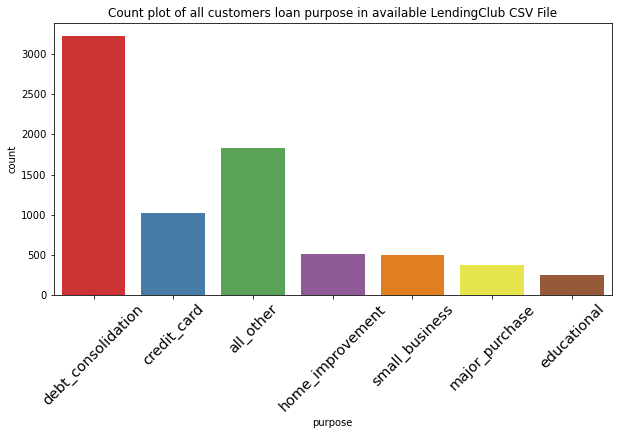

In [168]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=approved_loan_data,
    x=approved_loan_data['purpose'],
    palette='Set1'
)
plt.title('Count plot of all customers loan purpose in available LendingClub CSV File')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, fontsize='x-large')

Are these catorgies within this feature revelant? Below we'll separate each of these categories and take a look at how they vary with interest rates for those that were approved a loan.

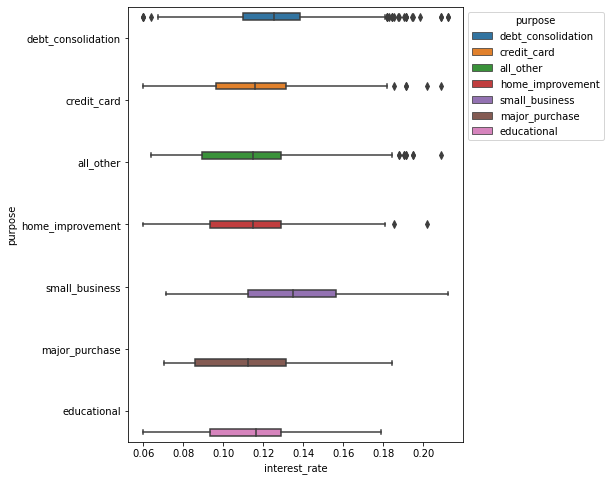

In [169]:
plt.figure(figsize = (6,8))
ax = sns.boxplot(data=approved_loan_data, y="purpose", x="interest_rate", hue="purpose")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

We can see that from above, the purpose of the loan does have an affect on the interest rate given.

# Taking a look at interests rates given

Text(0.5, 1.0, 'Histogram of all approved customers interest rate')

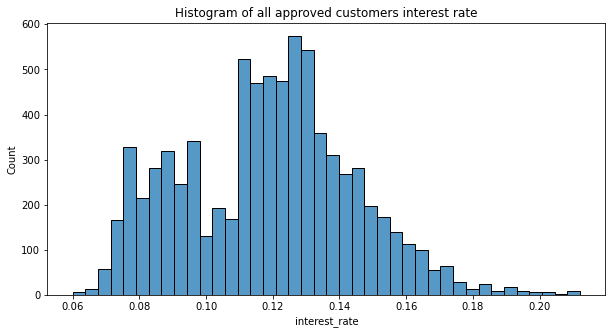

In [170]:
#histogram with bins for all loan_data in entirety
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['interest_rate'],
    bins=40,
    palette='Set1'
)
plt.title('Histogram of all approved customers interest rate')

Could there be a difference in those who are approved and those that are not approved?

Text(0.5, 1.0, 'Histogram of all customers interest rate')

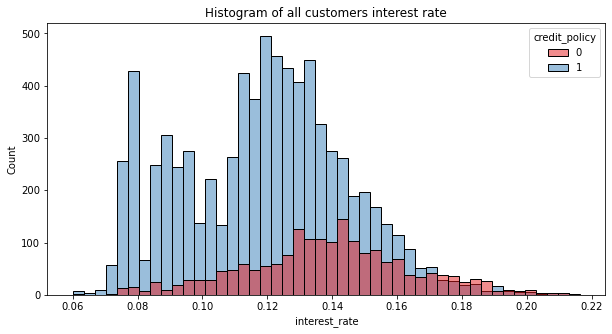

In [171]:
#histogram with bins for all approved loan_data in entirety
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=loan_data,
    x=loan_data['interest_rate'],
    hue='credit_policy',
    palette='Set1'
)
plt.title('Histogram of all customers interest rate')

In [172]:
approved_loan_data['interest_rate'].describe()

count    7710.000000
mean        0.118754
std         0.025571
min         0.060000
25%         0.097600
50%         0.118900
75%         0.135700
max         0.212100
Name: interest_rate, dtype: float64

In [173]:
non_approved_loan_data['interest_rate'].describe()

count    1868.000000
mean        0.138680
std         0.026032
min         0.060000
25%         0.122200
50%         0.138700
75%         0.154500
max         0.216400
Name: interest_rate, dtype: float64

We are aware that there are 9,578 observations in the loan data. Meaning there are 9,578 interest rates recorded in the histogram. However knowing that there is a feature called "credit policy" that represents whether a loan was able to get underwritten or not, would mean that individuals who were not underwritten a loan, technically have an interest rate of 0%.

Despite both non-approved and approved customers having the same potential maximum and minimum interest rate, we can see from our summary statistic that those who were generally not approved, had on average a higher interest rate of 2% than those approved.

# Installment plans examination

Text(0.5, 1.0, 'Histogram of all approved customers number of months for installments')

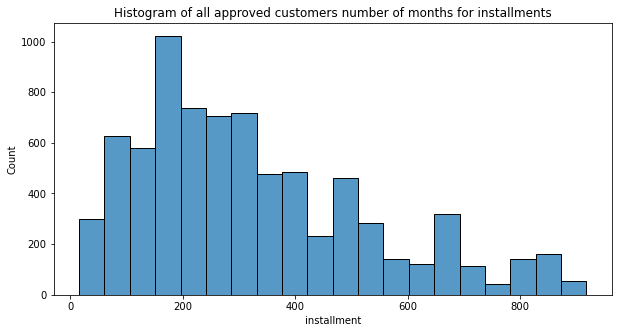

In [174]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['installment'],
    bins=20,
    palette='Set1'
)
plt.title('Histogram of all approved customers number of months for installments')

Text(0.5, 1.0, 'Histogram of all customers number of months for installments')

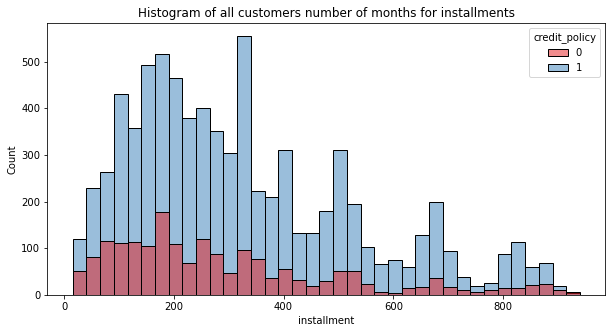

In [175]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=loan_data,
    x=loan_data['installment'],
    hue='credit_policy',
    palette='Set1'
)
plt.title('Histogram of all customers number of months for installments')

# Incomes relation with credit policy

Text(0.5, 1.0, 'Count plot of all approved customers incomes (natural log scaled)')

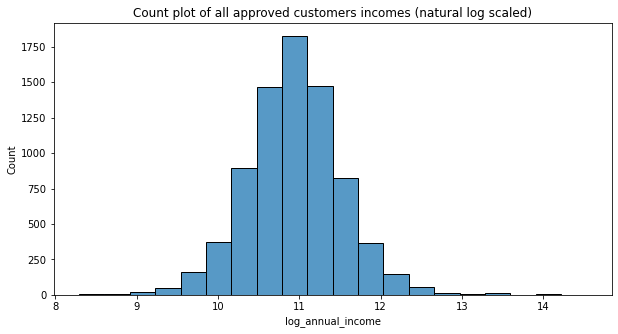

In [176]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['log_annual_income'],
    bins=20,
    palette='Set1'
)
plt.title('Count plot of all approved customers incomes (natural log scaled)')

# Plot of all approved customers DTI-ratio

Text(0.5, 1.0, 'Histogram plot of all approved customers debt_to_income_ratio')

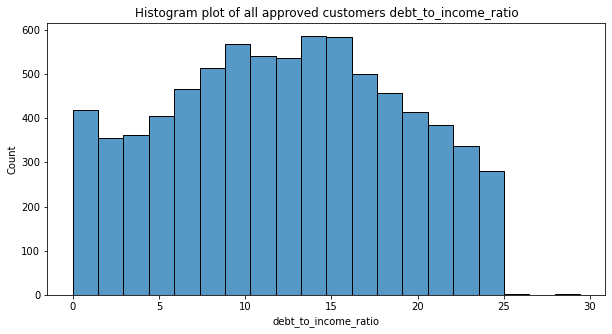

In [177]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['debt_to_income_ratio'],
    bins=20,
    palette='Set1'
)
plt.title('Histogram plot of all approved customers debt_to_income_ratio')

# Examing FICO Scores

Text(0.5, 1.0, 'Histogram plot of all customers fico scores')

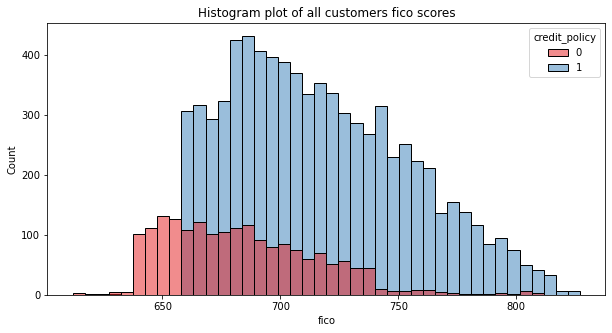

In [178]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=loan_data,
    x=loan_data['fico'],
    hue='credit_policy',
    palette='Set1'
)
plt.title('Histogram plot of all customers fico scores')

This plot makes conventional sense; generally individuals with lower FICO scores are less likely to be approved for loans.

Text(0.5, 1.0, 'Histogram plot of all approved customers fico scores')

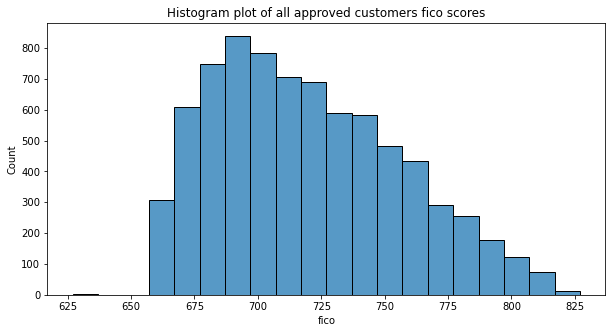

In [179]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['fico'],
    bins=20,
    palette='Set1'
)
plt.title('Histogram plot of all approved customers fico scores')

In [180]:
approved_loan_data['fico'].describe()

count    7710.000000
mean      717.356031
std        36.630697
min       627.000000
25%       687.000000
50%       712.000000
75%       742.000000
max       827.000000
Name: fico, dtype: float64

# How does credit line affect things?

Text(0.5, 1.0, 'Histogram plot of all customers days with credit line')

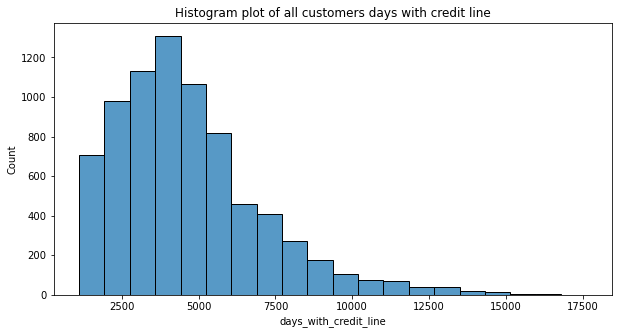

In [181]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['days_with_credit_line'],
    bins=20,
    palette='Set1'
)
plt.title('Histogram plot of all customers days with credit line')

In [182]:
#this feature needs a transformation, can remove outliers and replace with the median, it'll help with the distribution
#box-cox transformation, square, and log transformation

# Examing revolving balances of those approved

Text(0.5, 1.0, 'Histogram plot of all approved customers revolving balance')

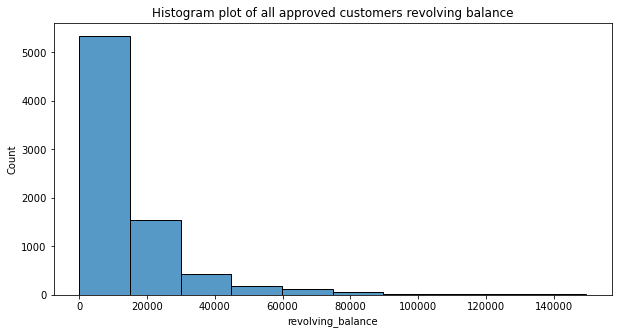

In [183]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['revolving_balance'],
    bins=10,
    palette='Set1'
)
plt.title('Histogram plot of all approved customers revolving balance')

In [184]:
counts, bin_edges = np.histogram(approved_loan_data['revolving_balance'], bins=10)
print('bin counts', counts)
print('bin edges are:', bin_edges)

bin counts [5339 1539  431  175  114   50   23   17   13    9]
bin edges are: [     0.   14952.7  29905.4  44858.1  59810.8  74763.5  89716.2 104668.9
 119621.6 134574.3 149527. ]


In [185]:
approved_loan_data['revolving_balance'].describe()

count      7710.000000
mean      13798.404280
std       16878.560424
min           0.000000
25%        3334.250000
50%        8707.500000
75%       17579.750000
max      149527.000000
Name: revolving_balance, dtype: float64

This graph is heavily skewed, it showes that a majority of customers (50% of the approved customers) have somewhere between 0 to ~18,000 dollars of revolving debt unpaid.

In [186]:
#make sure to do a transformation for this feature

# Examining approved customers credit line revolving utilization

Text(0.5, 1.0, 'Histogram plot of all approved customers percentage of revolving utilization of credit line')

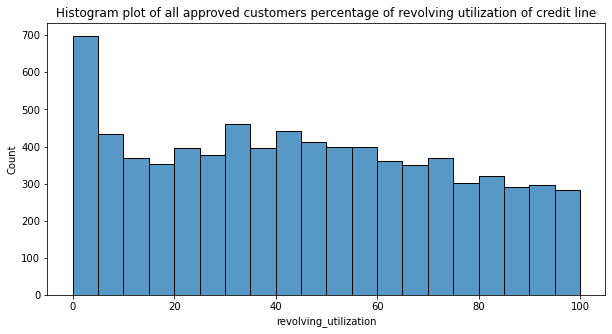

In [187]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['revolving_utilization'],
    bins=20,
    palette='Set1'
)
plt.title('Histogram plot of all approved customers percentage of revolving utilization of credit line')

We can see that there's a fairly even distribution of percentage of revolving utilization of credit line. With the exception of the mode being the bin for individuals with a percentage of revolving utilization between 0 to 5 percent.

# Approved customers hard inquiries count

Text(0.5, 1.0, 'Histogram plot of all approved customers last 6 months count of inquiries')

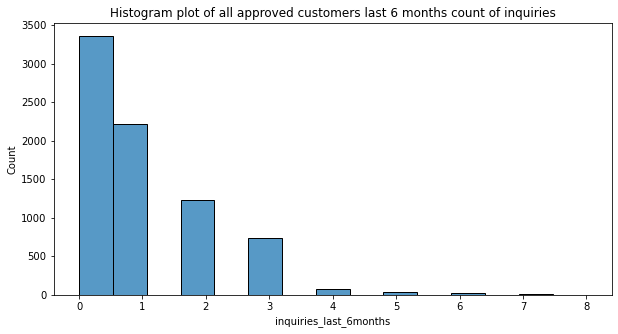

In [188]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['inquiries_last_6months'],
    bins=15,
    palette='Set1'
)
plt.title('Histogram plot of all approved customers last 6 months count of inquiries')

Individuals that were approved for a loan tend to have not have hard inquiries totaling more than 3. 

# Looking at approved customer loan payment delinquincies

Text(0.5, 1.0, 'Histogram plot of all approved customers number of delinquincies in the past 2 years')

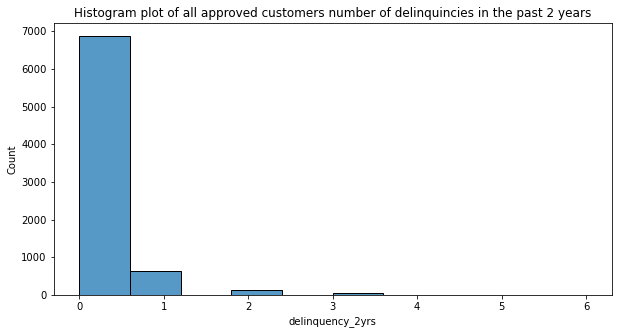

In [189]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['delinquency_2yrs'],
    bins=10,
    palette='Set1'
)
plt.title('Histogram plot of all approved customers number of delinquincies in the past 2 years')

In [190]:
counts, bin_edges = np.histogram(approved_loan_data['delinquency_2yrs'], bins=10)
print('bin counts', counts)
print('bin edges are:', bin_edges)

bin counts [6876  644    0  129    0   47   10    0    3    1]
bin edges are: [0.  0.6 1.2 1.8 2.4 3.  3.6 4.2 4.8 5.4 6. ]


# Approved customer's public record

Text(0.5, 1.0, 'Histogram plot of all approved customers number of events on public records')

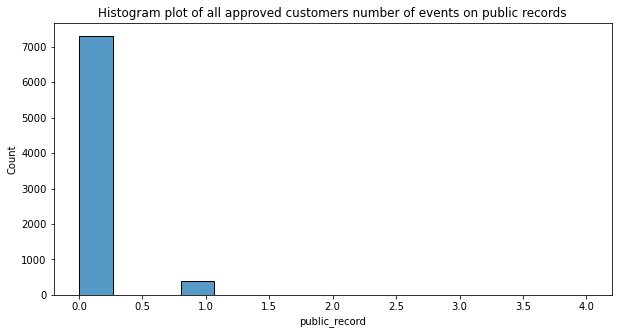

In [191]:
plt.figure(figsize=(10,5))
chart = sns.histplot(
    data=approved_loan_data,
    x=approved_loan_data['public_record'],
    bins=15,
    palette='Set1'
)
plt.title('Histogram plot of all approved customers number of events on public records')

In [192]:
#near zero variance variable, check the threshold to see how much of the data has to be the same, if we meet that, it's
#considerable to be removed, need to know if it's keepable

In [193]:
counts, bin_edges = np.histogram(approved_loan_data['public_record'], bins=15)
print('bin counts', counts)
print('bin edges are:', bin_edges)

bin counts [7303    0    0  394    0    0    0    9    0    0    0    3    0    0
    1]
bin edges are: [0.         0.26666667 0.53333333 0.8        1.06666667 1.33333333
 1.6        1.86666667 2.13333333 2.4        2.66666667 2.93333333
 3.2        3.46666667 3.73333333 4.        ]


In [194]:
#need to remove outliers, take away anything beyond what seems like 3 standard deviations

# Can approved customers with existing lending club loans, loan again?

[Text(0, 0, '0'), Text(1, 0, '1')]

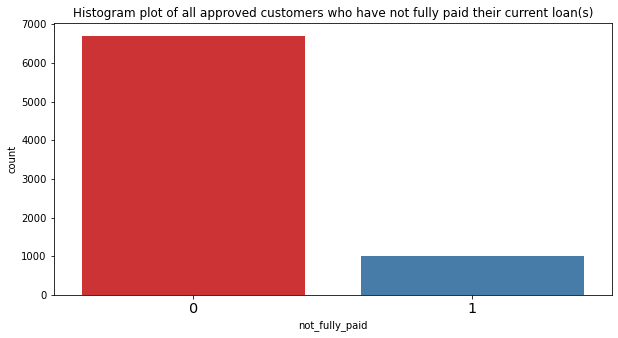

In [195]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=approved_loan_data,
    x=approved_loan_data['not_fully_paid'],
    palette='Set1'
)
plt.title('Histogram plot of all approved customers who have not fully paid their current loan(s)')
chart.set_xticklabels(chart.get_xticklabels(), rotation=0, fontsize='x-large')

#  Predictive power score

In [196]:
def heatmap(df):
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
    ax.set_title('PPS matrix')
    ax.set_xlabel('feature')
    ax.set_ylabel('target')
    return ax

In [197]:
#here he are testing the pps to predict the relationship between the first feature for inputs, 
#to the output variable interest rate
pps.score(approved_loan_data, "credit_policy", "interest_rate")

{'x': 'credit_policy',
 'y': 'interest_rate',
 'ppscore': 0,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'baseline_score': 0.02054034,
 'model_score': 0.020552663541333338,
 'model': DecisionTreeRegressor()}

Note to self: Credit policy has already been chosen to be of only value of 1, as that means the candidate has an approved loan.
This feature can be omitted in the one_hot_encoded_df we'll be making.

In [198]:
print(approved_loan_data.columns)

Index(['credit_policy', 'purpose', 'interest_rate', 'installment',
       'log_annual_income', 'debt_to_income_ratio', 'fico',
       'days_with_credit_line', 'revolving_balance', 'revolving_utilization',
       'inquiries_last_6months', 'delinquency_2yrs', 'public_record',
       'not_fully_paid'],
      dtype='object')


In [199]:
new_approved_loan_data = approved_loan_data.drop('credit_policy', axis=1,)

In [200]:
print(new_approved_loan_data .columns)

Index(['purpose', 'interest_rate', 'installment', 'log_annual_income',
       'debt_to_income_ratio', 'fico', 'days_with_credit_line',
       'revolving_balance', 'revolving_utilization', 'inquiries_last_6months',
       'delinquency_2yrs', 'public_record', 'not_fully_paid'],
      dtype='object')


In [201]:
one_hot_encoded_df= pd.get_dummies(new_approved_loan_data, columns=['purpose', 'not_fully_paid'])

In [202]:
print(one_hot_encoded_df.head())

   interest_rate  installment  log_annual_income  debt_to_income_ratio  fico  \
0         0.1189       829.10          11.350407                 19.48   737   
1         0.1071       228.22          11.082143                 14.29   707   
2         0.1357       366.86          10.373491                 11.63   682   
3         0.1008       162.34          11.350407                  8.10   712   
4         0.1426       102.92          11.299732                 14.97   667   

   days_with_credit_line  revolving_balance  revolving_utilization  \
0            5639.958333              28854                   52.1   
1            2760.000000              33623                   76.7   
2            4710.000000               3511                   25.6   
3            2699.958333              33667                   73.2   
4            4066.000000               4740                   39.5   

   inquiries_last_6months  delinquency_2yrs  public_record  purpose_all_other  \
0                

In [203]:
matrix_df = pps.matrix(one_hot_encoded_df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [204]:
matrix_df

x,days_with_credit_line,debt_to_income_ratio,delinquency_2yrs,fico,inquiries_last_6months,installment,interest_rate,log_annual_income,not_fully_paid_0,not_fully_paid_1,public_record,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,revolving_balance,revolving_utilization
y,,,,,,,,,,,,,,,,,,,,
days_with_credit_line,1.0,0.0,0.000000,0.016837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
debt_to_income_ratio,0.0,1.0,0.000000,0.043567,0.000069,0.000000,0.016515,0.000000,0.000709,0.000709,0.000000,0.007478,0.003733,0.016943,0.000000,0.006450,0.002884,0.002863,0.0,0.000000
delinquency_2yrs,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
fico,0.0,0.0,0.029978,1.000000,0.021768,0.133962,0.432983,0.000000,0.000000,0.000000,0.006020,0.000000,0.000000,0.010239,0.000000,0.000000,0.000000,0.000000,0.0,0.126285
inquiries_last_6months,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
installment,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.060725,0.012474,0.000000,0.000000,0.000000,0.000883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
interest_rate,0.0,0.0,0.011809,0.347504,0.002171,0.394650,1.000000,0.000000,0.004271,0.004271,0.001395,0.005710,0.000060,0.010628,0.000000,0.000883,0.001209,0.008407,0.0,0.030581
log_annual_income,0.0,0.0,0.000261,0.000679,0.000000,0.000000,0.000000,1.000000,0.000162,0.000162,0.000000,0.002365,0.000962,0.001184,0.002276,0.008707,0.000124,0.002856,0.0,0.000000
not_fully_paid_0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


<AxesSubplot:title={'center':'PPS matrix'}, xlabel='feature', ylabel='target'>

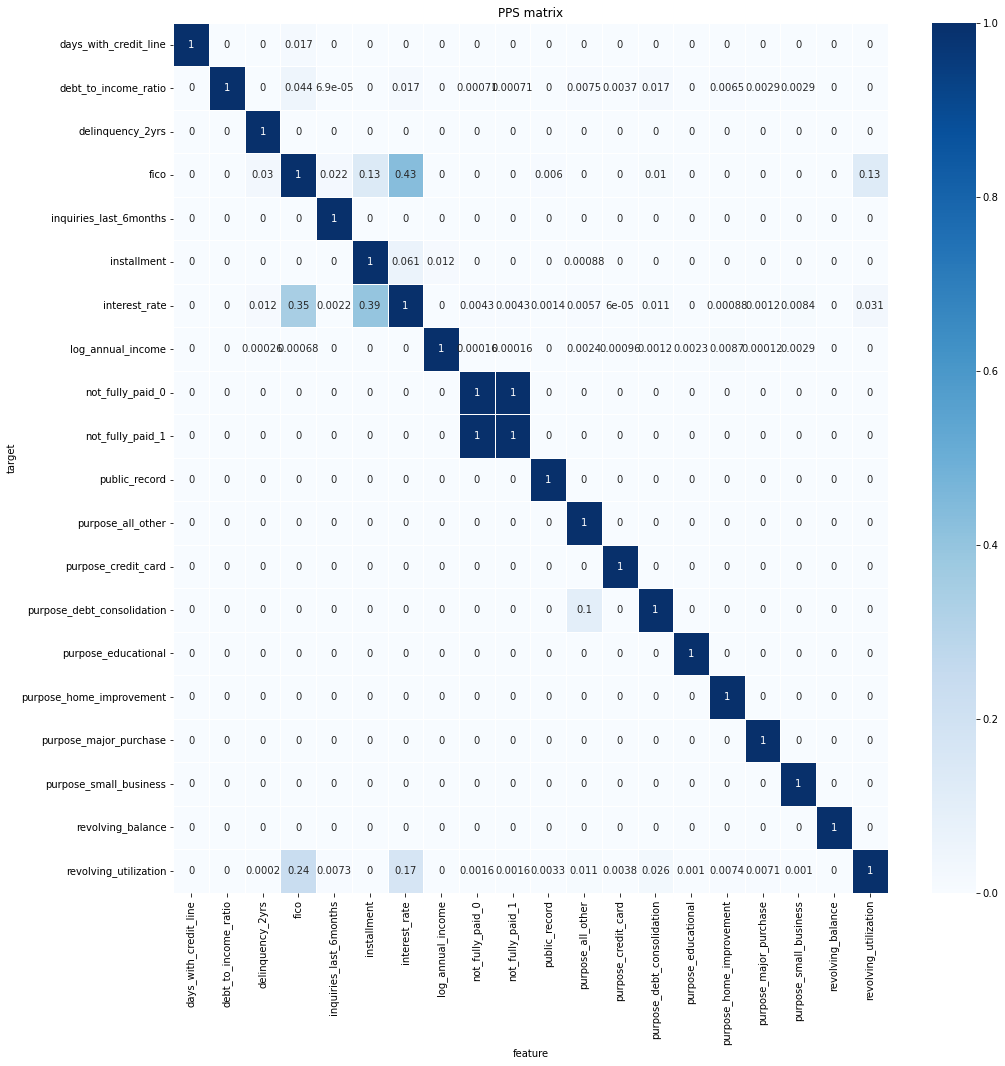

In [205]:
plt.figure(figsize=(16,16))
heatmap(matrix_df)

Shown above in the heatmap, ppscore tells us whether the feature x, is useful in predicting the "target" variable y. It uses a value between 0 and 1, 0 being no predictive power and 1, meaning very high predictive power that the x variable, or feature, is capable of predicting the output variable. We can now isolate the array of ppscores to target "interest rate" to each feature and see which features we can move forward with.

In [208]:
#interest rate row, values for ppscore shown
matrix_df.iloc[6]

x
days_with_credit_line         0.000000
debt_to_income_ratio          0.000000
delinquency_2yrs              0.011809
fico                          0.347504
inquiries_last_6months        0.002171
installment                   0.394650
interest_rate                 1.000000
log_annual_income             0.000000
not_fully_paid_0              0.004271
not_fully_paid_1              0.004271
public_record                 0.001395
purpose_all_other             0.005710
purpose_credit_card           0.000060
purpose_debt_consolidation    0.010628
purpose_educational           0.000000
purpose_home_improvement      0.000883
purpose_major_purchase        0.001209
purpose_small_business        0.008407
revolving_balance             0.000000
revolving_utilization         0.030581
Name: interest_rate, dtype: float64

From the Predictive power score we find that for the output variable, interest_rate, the following 4 columns or features have the strongest predictive power from greatest to least: installment(approx. 0.39), fico(approx. 0.35), delinquency_2yrs (approx. 0.012), purpose_debt_consolidation (approx. 0.011). It's arguable to say that the 2 most predictive features are the installment and fico score feature.

# Evaluating correlation of features

In [207]:
one_hot_encoded_df.corr()

,interest_rate,installment,log_annual_income,debt_to_income_ratio,fico,days_with_credit_line,revolving_balance,revolving_utilization,inquiries_last_6months,delinquency_2yrs,public_record,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,not_fully_paid_0,not_fully_paid_1
interest_rate,1.000000,0.321136,0.054357,0.177440,-0.720964,-0.145776,0.107150,0.490835,0.039724,0.161940,0.095648,-0.133240,-0.051336,0.139486,-0.031657,-0.065729,-0.068935,0.171779,-0.141907,0.141907
installment,0.321136,1.000000,0.424872,0.046935,0.041165,0.146923,0.265013,0.087740,0.015539,0.008326,-0.037786,-0.197387,0.001877,0.175388,-0.092722,0.020164,-0.083632,0.107478,-0.054171,0.054171
log_annual_income,0.054357,0.424872,1.000000,-0.107780,0.090025,0.293900,0.412783,0.044072,0.035898,0.029289,0.009049,-0.075603,0.069060,-0.029271,-0.103240,0.119852,-0.021061,0.066613,0.043460,-0.043460
debt_to_income_ratio,0.177440,0.046935,-0.107780,1.000000,-0.261599,0.012261,0.243598,0.334319,-0.015780,-0.020940,-0.005521,-0.124624,0.088608,0.181398,-0.025569,-0.110416,-0.073235,-0.076252,-0.025542,0.025542
fico,-0.720964,0.041165,0.090025,-0.261599,1.000000,0.250544,-0.074839,-0.577790,0.004061,-0.222789,-0.152966,0.081210,-0.010223,-0.177523,0.003463,0.111179,0.069125,0.054445,0.110967,-0.110967
days_with_credit_line,-0.145776,0.146923,0.293900,0.012261,0.250544,1.000000,0.225442,-0.046825,0.000033,0.083295,0.060802,-0.051219,0.043075,-0.021653,-0.019787,0.073573,-0.003512,0.015758,0.023782,-0.023782
revolving_balance,0.107150,0.265013,0.412783,0.243598,-0.074839,0.225442,1.000000,0.341571,-0.004217,-0.047358,-0.041504,-0.127405,0.123378,0.070413,-0.043451,-0.016380,-0.087090,0.033444,-0.022756,0.022756
revolving_utilization,0.490835,0.087740,0.044072,0.334319,-0.577790,-0.046825,0.341571,1.000000,-0.083082,-0.040359,0.070676,-0.146873,0.091922,0.218834,-0.052299,-0.124319,-0.103600,-0.057409,-0.076386,0.076386
inquiries_last_6months,0.039724,0.015539,0.035898,-0.015780,0.004061,0.000033,-0.004217,-0.083082,1.000000,-0.007266,0.006547,0.012030,-0.032713,-0.059336,0.016788,0.062491,0.010472,0.058870,-0.074090,0.074090
delinquency_2yrs,0.161940,0.008326,0.029289,-0.020940,-0.222789,0.083295,-0.047358,-0.040359,-0.007266,1.000000,-0.006707,0.011848,-0.000861,-0.006450,0.000975,-0.003680,0.002424,-0.005505,-0.013751,0.013751


In [217]:
def heatmap_corr(df):
    ax = sns.heatmap(df, vmin=-1, vmax=1, center=0, linewidths=0.5, annot=True)
    ax.set_title('Pearson Correlation matrix')
    ax.set_xlabel('feature')
    ax.set_ylabel('target')
    return ax

<AxesSubplot:title={'center':'Pearson Correlation matrix'}, xlabel='feature', ylabel='target'>

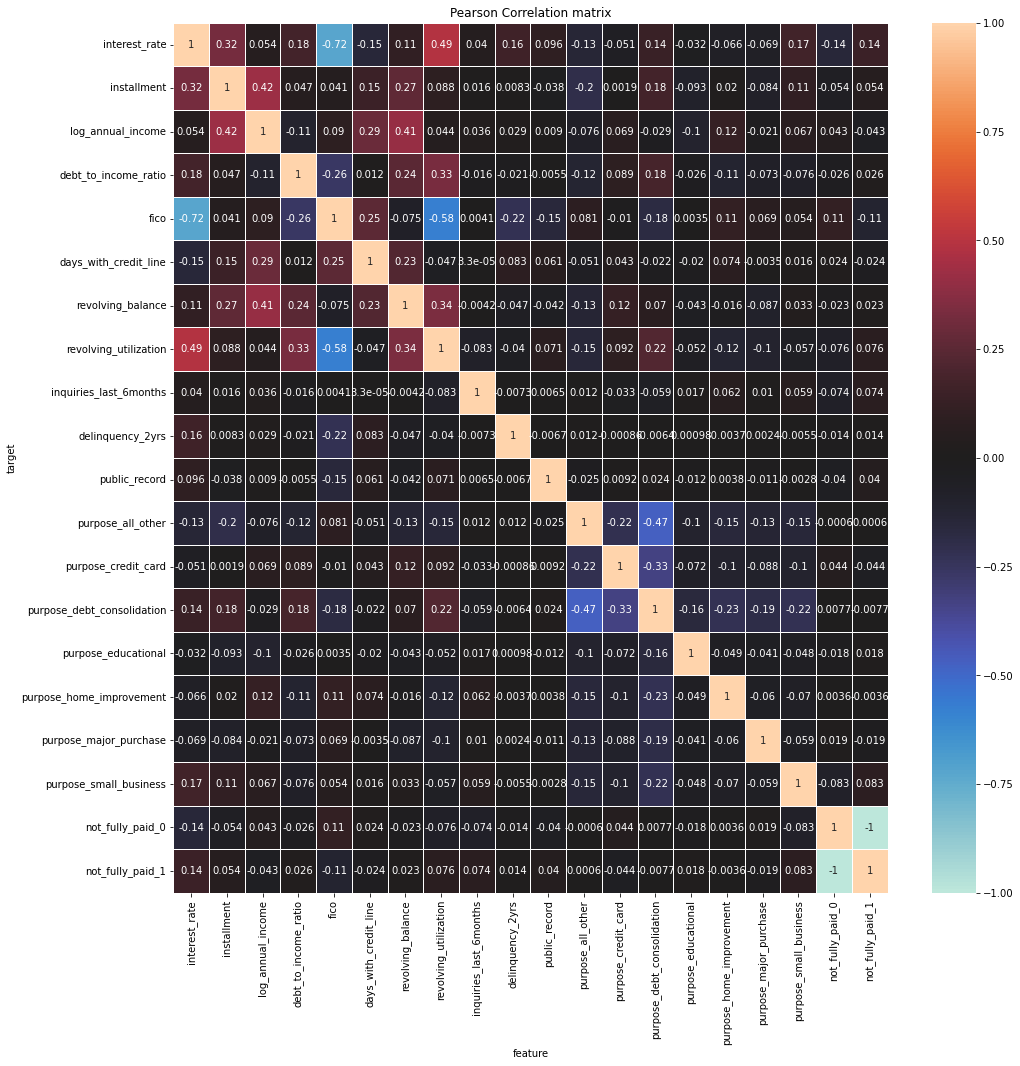

In [218]:
plt.figure(figsize=(16,16))
heatmap_corr(one_hot_encoded_df.corr())

The pearson's correlation method of finding relationshups between our features and the output variable interest_rate, shows different results on which features are important to move forward with than the predictive power score approach. The following features have a magnitude of correlation above 0.3: installment, fico, and revolving_utilization. Shockingly, many of the features show little to no correlation the interest rate. 